#RECOMMENDING HOTELS BASED ON NEARBY PLACES - CLUSTERING APPROACH

###Introduction

New York is my dream trip, so I decided to use Data Science to choose the perfect hotel for me. This project will segment all possible accommodation hotels on the trip, and then create a system to suggest them based on nearby establishments, thus seeking to increase the probability of high destination satisfaction.

###Data

The data used were obtained from the Foursquare API, performed in 3 steps.


1. I start by carrying out a search in the entire area of ​​the city, looking for all the hotels in it, and segregating the following information:
*   City
*   Latitude
*   Longitude
*   Hotel name
*   Hotel latitude
*   Hotel longitude
*   Hotel Type

2. After, we will make the third request to obtain all nearby establishments within a radius of 300 m and save the following information.
*   Name of the establishment
*   Latitude of the Establishment
*   Longitude of the Establishment
*   Type of Establishment

3. Finally, I choose one of the clusters based on the rating of my favorite hotel in Rio de Janeiro.

###Packages

In [ ]:
#Library of tools for numerical computation
import numpy as np

#Used to Visualize, Manipulate and Analyse structured data
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
#Used to Manipulate JSON (JavaScript Object Notation) files.
import json
#Used to HTTP requests
import requests

#It is used for data visualization, through graphs and maps
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
#Is a Python data visualization library based on matplotlib.
import seaborn as sns

#The library for implementing and evaluating Machine Learning models
from sklearn.cluster import KMeans

#!pip install geopy
#!pip install folium==0.5.0
#It is used to generate visualization of interactive maps
import folium
#Used to get geographic coordinates
from geopy.geocoders import Nominatim

#Module used for screen viewing
from IPython.display import Image

from sklearn.decomposition import PCA

print("All packages have been imported")

All packages have been imported


In [ ]:
#Setting matplotlib style
plt.style.use("fivethirtyeight")

###Foursquare Credentials and Version

As determined, it will be the platform used to acquire hotel information.

In [ ]:
CLIENT_ID = 'QKP3D0L0NIMGMXHO1HLXGI4TN3V1TLZPGKJASOI5X2KT1MKM' # your Foursquare ID
CLIENT_SECRET = 'EKGRIM3P3PKH0LDB4MPPOYRYRXQ24ESBMG0FXLSBZXPVLVJJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'LV4L52LUUB13FHLC0I32OA3XI2Q5LGVEOTLZWOSIMXPT204I' # your FourSquare Access Token

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QKP3D0L0NIMGMXHO1HLXGI4TN3V1TLZPGKJASOI5X2KT1MKM
CLIENT_SECRET:EKGRIM3P3PKH0LDB4MPPOYRYRXQ24ESBMG0FXLSBZXPVLVJJ


###Getting New York coordinates from the geopy library:

In [ ]:
address = 'New York, United States'

geolocator = Nominatim(user_agent="newyork_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


###Searching for Hotels in New York

1. Defining the hotel search by Fousquare's internal code (hotel code)
2. Although we set the search radius to 10000 meters, the default search result returned is only 100 locations, due to the limitation of the Foursquare API.

In [ ]:
radius = 10000 #set the radius search 
hotel_foursquare_code = '4bf58dd8d48988d1fa931735'
url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    hotel_foursquare_code,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d1fa931735&client_id=QKP3D0L0NIMGMXHO1HLXGI4TN3V1TLZPGKJASOI5X2KT1MKM&client_secret=EKGRIM3P3PKH0LDB4MPPOYRYRXQ24ESBMG0FXLSBZXPVLVJJ&v=20180605&ll=40.7127281,-74.0060152&radius=10000&limit=100'

###Retrieving data and storing in a DataFrame

In [ ]:
results = requests.get(url).json()["response"]['groups'][0]['items']
results
name = address
venues_list=[]

venues_list.append([(
    name, 
    latitude, 
    longitude, 
    v['venue']['name'], 
    v['venue']['id'], 
    v['venue']['location']['lat'], 
    v['venue']['location']['lng'],  
    v['venue']['categories'][0]['name']) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

nearby_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"New York, United States",40.712728,-74.006015,The Roxy Hotel,3fd66200f964a520bbe61ee3,40.719341,-74.005044,Hotel
1,"New York, United States",40.712728,-74.006015,Crosby Street Hotel,4ac7e4a7f964a52065ba20e3,40.723011,-73.997454,Hotel
2,"New York, United States",40.712728,-74.006015,Conrad New York Downtown,4f22ca77e4b0ed3396a83a05,40.715035,-74.015840,Hotel
3,"New York, United States",40.712728,-74.006015,SoHo Grand Hotel,3fd66200f964a52053eb1ee3,40.721974,-74.004464,Hotel
4,"New York, United States",40.712728,-74.006015,The Bowery Hotel,4ab04eb9f964a520fe6620e3,40.726145,-73.991627,Hotel


### Filtering the dataframe by 'Venue Category' that indicates 'Hotel'
To make sure that the dataframe only has places categorized as 'Hotel', through filtering by category.

In [ ]:
nearby_venues = nearby_venues[nearby_venues['Venue Category'].str.contains('Hotel')]
nearby_venues.reset_index(inplace=True, drop=True)
print(nearby_venues.shape)
nearby_venues.head()

(99, 8)


,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"New York, United States",40.712728,-74.006015,The Roxy Hotel,3fd66200f964a520bbe61ee3,40.719341,-74.005044,Hotel
1,"New York, United States",40.712728,-74.006015,Crosby Street Hotel,4ac7e4a7f964a52065ba20e3,40.723011,-73.997454,Hotel
2,"New York, United States",40.712728,-74.006015,Conrad New York Downtown,4f22ca77e4b0ed3396a83a05,40.715035,-74.015840,Hotel
3,"New York, United States",40.712728,-74.006015,SoHo Grand Hotel,3fd66200f964a52053eb1ee3,40.721974,-74.004464,Hotel
4,"New York, United States",40.712728,-74.006015,The Bowery Hotel,4ab04eb9f964a520fe6620e3,40.726145,-73.991627,Hotel


### I will save the DataFrame on my GoogleDrive by installing PyDrive.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
nearby_venues.to_csv('newyork_nearby_venues.csv', index=False)

#Getting ratings from Hotel

###Creating Subset with rating

In [ ]:
nearby_venues_50 = nearby_venues.tail(50)
nearby_venues_50.to_csv('newyork_nearby_venues_50.csv', index=False)
nearby_venues_50.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
49,"New York, United States",40.712728,-74.006015,InterContinental New York Barclay,4a7b8beaf964a52058eb1fe3,40.755663,-73.973528,Hotel
50,"New York, United States",40.712728,-74.006015,The Roger New York,4a7c0c8ff964a520dceb1fe3,40.745797,-73.984277,Hotel
51,"New York, United States",40.712728,-74.006015,Walker Hotel Greenwich Village,571558a2498e2f199298d02b,40.736180,-73.996600,Hotel
52,"New York, United States",40.712728,-74.006015,SIXTY LES Hotel,4b5668d6f964a520370f28e3,40.722141,-73.988571,Hotel
53,"New York, United States",40.712728,-74.006015,Hyatt Regency Jersey City On The Hudson,4a86e69ff964a5208a0120e3,40.717083,-74.032679,Hotel


###Retrieve Rating

In [ ]:
#Defining a function that request the ratings score for each Hotel contained in the dataframe
def get_rating(df):
    
    ratings = []
    for venue_id in df['Venue Id']:
        hotel_foursquare_id = venue_id

        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            hotel_foursquare_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        results = requests.get(url).json()["response"]["venue"]["rating"]
        ratings.append(results)
    
    df.insert(5, 'Ratings', ratings)

In [ ]:
get_rating(nearby_venues_50)
nearby_venues_50.head()

,City,City Latitude,City Longitude,Venue,Venue Id,Ratings,Venue Latitude,Venue Longitude,Venue Category
49,"New York, United States",40.712728,-74.006015,InterContinental New York Barclay,4a7b8beaf964a52058eb1fe3,8.3,40.755663,-73.973528,Hotel
50,"New York, United States",40.712728,-74.006015,The Roger New York,4a7c0c8ff964a520dceb1fe3,7.8,40.745797,-73.984277,Hotel
51,"New York, United States",40.712728,-74.006015,Walker Hotel Greenwich Village,571558a2498e2f199298d02b,8.9,40.736180,-73.996600,Hotel
52,"New York, United States",40.712728,-74.006015,SIXTY LES Hotel,4b5668d6f964a520370f28e3,8.3,40.722141,-73.988571,Hotel
53,"New York, United States",40.712728,-74.006015,Hyatt Regency Jersey City On The Hudson,4a86e69ff964a5208a0120e3,8.5,40.717083,-74.032679,Hotel


Saving Dataframe

In [ ]:
nearby_venues_50.to_csv('newyork_nearby_venues_51_ratings.csv', index=False)

Merging the 2 CSV with the ratings, because Foursquare only allows 50 requests a day

In [ ]:
a = pd.read_csv('newyork_nearby_venues_50_ratings.csv')
b = pd.read_csv('newyork_nearby_venues_51_ratings.csv')
lista_df=[a,b]
merged = pd.concat(lista_df)
merged.to_csv('ratings.csv', index=False)


In [ ]:
hotels_ratings = merged[['Venue','Venue Id', 'Ratings']]
hotels_ratings.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
hotels_ratings.reset_index(inplace = True, drop=True)
hotels_ratings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Venue,Venue Id,Ratings
0,The Roxy Hotel,3fd66200f964a520bbe61ee3,8.7
1,Crosby Street Hotel,4ac7e4a7f964a52065ba20e3,9.1
2,Conrad New York Downtown,4f22ca77e4b0ed3396a83a05,8.7
3,SoHo Grand Hotel,3fd66200f964a52053eb1ee3,8.7
4,The Bowery Hotel,4ab04eb9f964a520fe6620e3,9.3
5,Andaz Wall Street - a concept by Hyatt,4b1b13ddf964a520bbf723e3,8.1
6,"The Standard, High Line",49d3d4a7f964a5201a5c1fe3,9.1
7,Ace Hotel New York,4a0e0f85f964a520bf751fe3,8.8
8,Kimpton Hotel Eventi,4bec60a5f909ef3b2808a9c6,8.9
9,Four Seasons Hotel New York Downtown,57c640ad498e74977f98372f,9.3


Saving Dataframe

In [ ]:
hotels_ratings.to_csv('hotels_ratings.csv', index=False)

In [ ]:
#test connection = if necessary
def test_conection():
    hotel_foursquare_id = '4b0563c0f964a5200e5822e3'
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        hotel_foursquare_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    url

    results = requests.get(url).json()
    print(results)

###Filtering Hotel Columns from DataFrame

In [ ]:
hotel_venues = nearby_venues[['Venue', 'Venue Latitude', 'Venue Longitude']]
hotel_venues.columns = ['Hotel', 'Hotel Latitude', 'Hotel Longitude']
hotel_venues.head()

,Hotel,Hotel Latitude,Hotel Longitude
0,The Roxy Hotel,40.719341,-74.005044
1,Crosby Street Hotel,40.723011,-73.997454
2,Conrad New York Downtown,40.715035,-74.015840
3,SoHo Grand Hotel,40.721974,-74.004464
4,The Bowery Hotel,40.726145,-73.991627


###Visualize all Hotels in a map

In [ ]:
# create map of hotels using latitude and longitude values
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, venue in zip(hotel_venues['Hotel Latitude'], hotel_venues['Hotel Longitude'], 
                                           hotel_venues['Hotel']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_hotels)  
    
map_hotels

The map created above is interactive, it may not be visible on github.

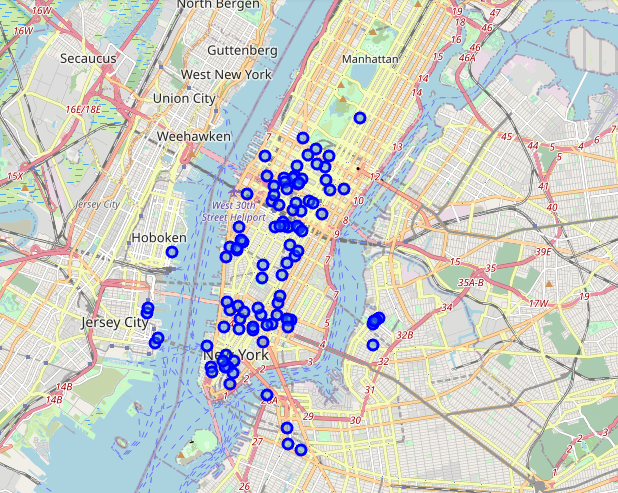

In [ ]:
Image(filename='folium_hotels_map.png')

#Get the top 100 venues that are in each Hotel within a radius of 300 meters

In [ ]:
#receives data from nearby venues from certain Hotel, using a request
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hotel', 
                  'Hotel Latitude', 
                  'Hotel Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting Nearby Venues

In [ ]:
get_venues = getNearbyVenues(names=nearby_venues['Venue'],
                                   latitudes=nearby_venues['Venue Latitude'],
                                   longitudes=nearby_venues['Venue Longitude'])

The Roxy Hotel
Crosby Street Hotel
Conrad New York Downtown
SoHo Grand Hotel
The Bowery Hotel
The Standard, High Line
Andaz Wall Street - a concept by Hyatt
Ace Hotel New York
The NoMad Hotel
Kimpton Hotel Eventi
Four Seasons Hotel New York Downtown
The Beekman, A Thompson Hotel
Gansevoort Meatpacking NYC
Dream Downtown
Gramercy Park Hotel
Hotel 50 Bowery
Greenwich Hotel
citizenM Bowery
W New York - Times Square
Andaz 5th Avenue - a concept by Hyatt
citizenM Hotel New York Times Square
Arlo SoHo
1 Hotel Brooklyn Bridge
Distrikt Hotel
PUBLIC
11 Howard
The Dominick
Artezen Hotel
The Plaza Hotel
The Ludlow Hotel
InterContinental New York Times Square
The Peninsula New York
Lotte New York Palace
Ink 48 Hotel
Pod 39 Hotel
Mercer Hotel
NOMO SOHO
Sofitel New York
Gild Hall, A Thompson Hotel
The Nolitan Hotel
Four Seasons Hotel
The Standard, East Village
Hotel Hugo
YOTEL New York
Warwick New York Hotel
The Marlton Hotel
SIXTY SoHo Hotel
New York Marriott Marquis
Hotel Indigo
InterContinental N

DataFrame Head's

In [ ]:
get_venues.head()

,Hotel,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Roxy Hotel,40.719341,-74.005044,Aire Ancient Baths,40.718141,-74.004941,Spa
1,The Roxy Hotel,40.719341,-74.005044,The Django,40.719365,-74.004880,Lounge
2,The Roxy Hotel,40.719341,-74.005044,Gotan,40.719217,-74.006642,Café
3,The Roxy Hotel,40.719341,-74.005044,Pepolino,40.720911,-74.005152,Italian Restaurant
4,The Roxy Hotel,40.719341,-74.005044,Spring Studios,40.720915,-74.006207,Event Space


Saving DataFrame

In [ ]:
get_venues.to_csv('newyork_get_venues.csv', index=False)

###Grouping DataFrame

In [ ]:
#counting how many locations were returned for each Hotel
get_venues.groupby('Hotel').count()

,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Hotel,,,,,,
1 Hotel Brooklyn Bridge,48,48,48,48,48,48
11 Howard,100,100,100,100,100,100
Ace Hotel Brooklyn,45,45,45,45,45,45
Ace Hotel New York,100,100,100,100,100,100
Andaz 5th Avenue - a concept by Hyatt,76,76,76,76,76,76
Andaz Wall Street - a concept by Hyatt,75,75,75,75,75,75
Arlo NoMad,100,100,100,100,100,100
Arlo SoHo,47,47,47,47,47,47
Artezen Hotel,88,88,88,88,88,88


Unique Categories

In [ ]:
print('There are {} uniques categories.'.format(len(get_venues['Venue Category'].unique())))

There are 345 uniques categories.


### PCA - i will reduce my dimensions

In [ ]:
pip install rogeriopradoj-paretochart

  Created wheel for rogeriopradoj-paretochart: filename=rogeriopradoj_paretochart-2.0.0-py3-none-any.whl size=6378 sha256=6163be548650af94ecc3c65fa854ca40d68ab2370ccda910e3e0de9ba3c06cb8
  Stored in directory: /root/.cache/pip/wheels/2f/8e/3d/5268e0388c792123e4f39c0d27730438dd1b66217d23da3bc4
Successfully built rogeriopradoj-paretochart


In [ ]:
from paretochart.paretochart import pareto

In [ ]:
#fuction to plot the grafh
def PlotaPCA(dfcorr, ncomponentes):
    pca = PCA(n_components=ncomponentes)
    pca.fit(dfcorr)
    fig, ax = plt.subplots(figsize=(16, 8))
    pareto(pca.explained_variance_ratio_);
    ax.set_xlabel('Components')
    ax.set_ylabel('Explained variance')
    plt.grid()

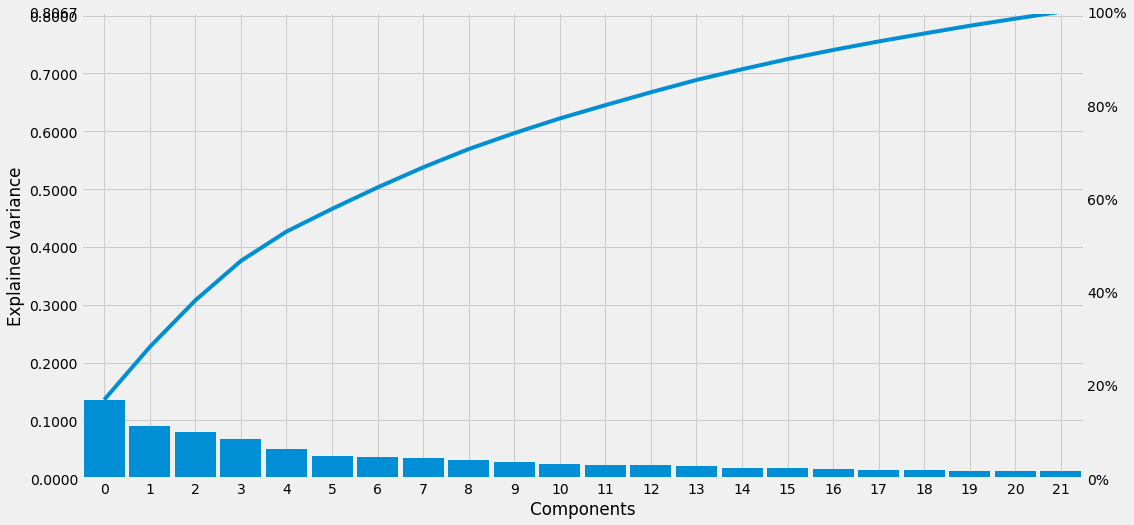

In [ ]:
PlotaPCA(newcategories, 0.8)
#using 0.8 to represent 80%

In [ ]:
pca = PCA(n_components=22)
newcategoriesPCA = pd.DataFrame(pca.fit_transform(newcategories), index=newcategories.index) 
newcategoriesPCA.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.003883,-0.023974,-0.058249,0.066414,0.015783,0.051492,-0.062540,-0.007377,0.005748,0.091115,0.014494,0.003938,-0.004296,-0.009842,-0.004084,-0.004396,0.020975,-0.012351,0.020183,0.067460,0.038716,0.013905
1,-0.019174,0.028921,0.007665,-0.052807,0.005139,0.008445,0.003483,0.035962,-0.004830,-0.016436,-0.012747,-0.001778,0.019928,0.008828,-0.009642,-0.005005,0.012291,-0.012214,-0.005946,-0.003476,-0.015238,0.015920
2,-0.023337,-0.031035,0.013732,-0.016860,0.028559,-0.011673,0.001042,-0.013715,0.034834,-0.039695,0.012844,-0.008468,-0.034800,0.015269,0.016578,0.027944,0.069169,-0.027759,0.053500,0.012108,-0.020628,0.016283
3,-0.052261,-0.106251,0.127250,0.036185,-0.035936,-0.000668,0.010205,0.023357,0.010717,-0.009799,-0.005365,0.014853,0.010004,0.009532,0.000445,-0.007843,-0.014672,0.006323,-0.007336,-0.003253,0.037150,-0.003544
4,-0.016003,0.007329,-0.013411,-0.027851,-0.006668,0.017296,0.016887,-0.021633,-0.007793,-0.021972,0.005056,-0.043139,-0.036816,-0.007858,-0.003939,0.002577,0.004598,0.006717,-0.007637,-0.011221,0.020853,-0.023108


###Analyze Each Hotel Center

In [ ]:
# one hot encoding
get_venues_onehot = pd.get_dummies(get_venues[['Venue Category']], prefix="", prefix_sep="")

# add Hotel column back to dataframe
get_venues_onehot['Hotel'] = get_venues['Hotel'] 

# heading dataframe
get_venues_onehot.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Res

Ordering columns

In [ ]:
# get columns name as list
cols = get_venues_onehot.columns.tolist()

# get index Hotel column
index = cols.index('Hotel')

# pop (remove) 'Hotel' from list
cols.pop(index)

# create list starting with [Hotel] + [list]
cols = ['Hotel'] + cols

# set new column order
get_venues_onehot = get_venues_onehot[cols]

# heading dataframe
get_venues_onehot.head()

,Hotel,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Res

In [ ]:
#DataFrame Size
get_venues_onehot.shape

(7411, 345)

Saving Dataframe

In [ ]:
get_venues_onehot.to_csv('newyork_get_venues_onehot.csv', index=False)

Grouping rows by Hotel, taking the mean frequency of occurrence for each category

In [ ]:
get_venues_grouped = get_venues_onehot.groupby('Hotel').mean().reset_index()
get_venues_grouped.head()

,Hotel,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Res

In [ ]:
# New dataframe size
get_venues_grouped.shape

(98, 345)

In [ ]:
#Saving Dataframe
get_venues_grouped.to_csv('newyork_get_venues_grouped.csv', index=False)

In [ ]:
#Creating a new DF, without the column 'Hotel', to fit the PCA
newcategories = get_venues_grouped.drop('Hotel', axis = 1)
newcategories.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restauran

###Get Top Most Commom Venues

In [ ]:
#print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in get_venues_grouped['Hotel']:
    print("----"+hood+"----")
    temp = get_venues_grouped[get_venues_grouped['Hotel'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1 Hotel Brooklyn Bridge----
            venue  freq
0            Park  0.10
1  Ice Cream Shop  0.08
2   Boat or Ferry  0.08
3  Scenic Lookout  0.06
4     Pizza Place  0.04


----11 Howard----
                venue  freq
0  Italian Restaurant  0.08
1      Clothing Store  0.04
2                Café  0.04
3                 Spa  0.04
4         Coffee Shop  0.04


----Ace Hotel Brooklyn----
                       venue  freq
0     Furniture / Home Store  0.07
1  Middle Eastern Restaurant  0.04
2                        Spa  0.04
3               Cocktail Bar  0.04
4                        Bar  0.04


----Ace Hotel New York----
               venue  freq
0  Korean Restaurant  0.18
1          Hotel Bar  0.05
2       Dessert Shop  0.04
3             Bakery  0.03
4        Coffee Shop  0.03


----Andaz 5th Avenue - a concept by Hyatt----
                      venue  freq
0            Clothing Store  0.05
1               Coffee Shop  0.05
2  Mediterranean Restaurant  0.05
3       American Resta

###Put that into a pandas dataframe

In [ ]:
#a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
#puting into a dataframe
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues [1st, 2nd, 3rd, 4th, ..., nth]
columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hotel_venues_sorted = pd.DataFrame(columns=columns)
hotel_venues_sorted['Hotel'] = get_venues_grouped['Hotel']

for ind in np.arange(get_venues_grouped.shape[0]):
    hotel_venues_sorted.iloc[ind, 1:] = return_most_common_venues(get_venues_grouped.iloc[ind, :], num_top_venues)

hotel_venues_sorted.head()

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Hotel Brooklyn Bridge,Park,Ice Cream Shop,Boat or Ferry,Scenic Lookout,Juice Bar,Pizza Place,Pier,Café,Playground,American Restaurant
1,11 Howard,Italian Restaurant,Spa,Clothing Store,Café,Coffee Shop,Bakery,Furniture / Home Store,Bubble Tea Shop,Jewelry Store,Chinese Restaurant
2,Ace Hotel Brooklyn,Furniture / Home Store,French Restaurant,Bar,Bank,Middle Eastern Restaurant,Sandwich Place,Cocktail Bar,Spa,Gym / Fitness Center,Grocery Store
3,Ace Hotel New York,Korean Restaurant,Hotel Bar,Dessert Shop,New American Restaurant,Bakery,Gym / Fitness Center,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop
4,Andaz 5th Avenue - a concept by Hyatt,Mediterranean Restaurant,Coffee Shop,Clothing Store,Massage Studio,American Restaurant,Japanese Restaurant,French Restaurant,Sushi Restaurant,Steakhouse,Cocktail Bar


In [ ]:
#Saving DataFrame
hotel_venues_sorted.to_csv('newyork_hotel_venues_sorted.csv', index=False)

###Clustering Hotels

In [ ]:
#a new dataframe without 'Hotel' column
get_venues_grouped_clustering = get_venues_grouped.drop('Hotel', 1)
get_venues_grouped_clustering.head()

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restauran

In [ ]:
#Saving DataFrame
get_venues_grouped_clustering.to_csv('newyork_get_venues_grouped_clustering.csv', index=False)

#K-Means

###In this algorithm it is necessary to specify previously the k number of clusters (groups) in which the data will be grouped. Therefore, it is needed to find the best k number of clusters that results in the greatest possible similarity between data from the same cluster and at the lowest similarity between the different clusters.

To perform this task, I used several models with k values from 1 to 10, then two metrics were used to evaluate the results, known as, Elbow Method and Silhouette Method.

In [ ]:
#Best K - Elbow Method
def find_k(data, k = 10):
    
    cost = []
    
    for i in range (1, k+1):
        # run k-means clustering
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans = kmeans.fit(data)
        
        # calculates squared error for the clustered points
        cost.append(kmeans.inertia_)
    
    # plot (K Value) x (Squared Error - Cost)
    plt.plot(range(1, k+1), cost, linewidth='3')
    plt.xlabel("K Value")
    plt.xticks(np.arange(1, k+1, 1))
    plt.ylabel("Squared Error - Cost")
    plt.show

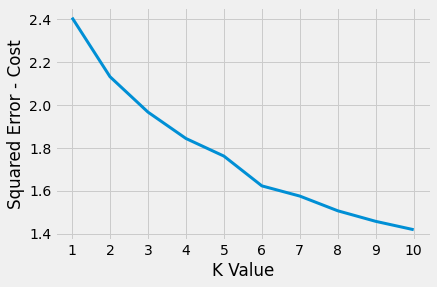

In [ ]:
find_k(get_venues_grouped_clustering)

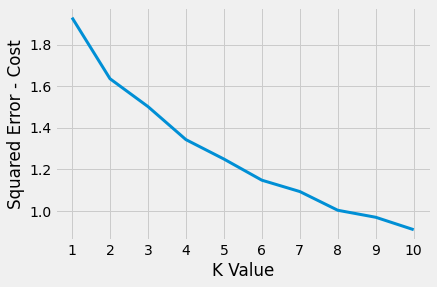

In [ ]:
find_k(newcategoriesPCA)

In [ ]:
#Best K - Silhouette Method
def find_kk(data, k = 10):
    from sklearn.metrics import silhouette_score
    
    sil = []
    
    for i in range (2, k+1):
        # run k-means clustering
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans = kmeans.fit(data)
        
        labels = kmeans.labels_
        
        # calculates squared error for the clustered points
        sil.append(silhouette_score(data, labels, metric='euclidean'))
    
    print(sil)
    # plot (K Value) x (Squared Error - Cost)
    plt.plot(range(2, k+1), sil, linewidth='3')
    plt.xlabel("K Value")
    plt.xticks(np.arange(1, k+1, 1))
    plt.ylabel("Silhouette Score")
    plt.show

[0.2332102459292108, 0.20903368705438058, 0.11218496569907449, 0.1025927756446047, 0.10204084106507318, 0.08316380307179926, 0.10147952046804126, 0.10669524097137419, 0.09109066360621197]


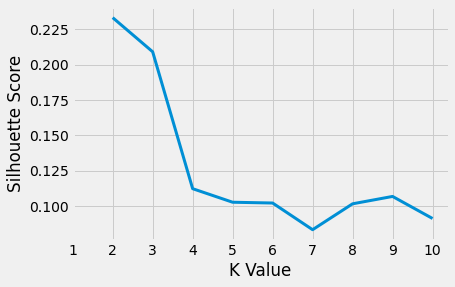

In [ ]:
find_kk(get_venues_grouped_clustering)

[0.3142522466726333, 0.11877466932413998, 0.15228710833872686, 0.1531124959403369, 0.13043312356896783, 0.141578994526423, 0.15563240718312854, 0.16259078517846506, 0.168218555604699]


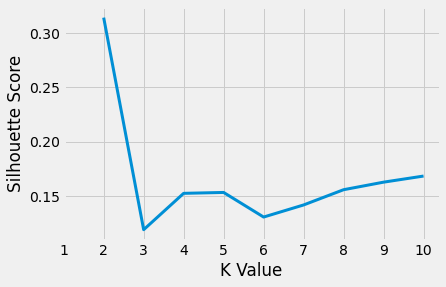

In [ ]:
find_kk(newcategoriesPCA)

###In this project I will use the first-best k (k = 4) according to the average of Elbow method and Silhouette method.

In [ ]:
# set number of clusters for the best k
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(get_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([3, 0, 3, 1, 0, 3, 1, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 3],
      dtype=int32)

In [ ]:
# set number of clusters for the best k
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newcategoriesPCA)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2],
      dtype=int32)

In [ ]:
# add clustering labels
hotel_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# set a new dataset
nearby_venues_merged = hotel_venues

# merge get_venues_grouped with hotel_venues to add latitude/longitude for each Hotel
nearby_venues_merged = nearby_venues_merged.join(hotel_venues_sorted.set_index('Hotel'), on='Hotel')

nearby_venues_merged.head()

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Roxy Hotel,40.719341,-74.005044,2,Coffee Shop,Gym / Fitness Center,Spa,French Restaurant,Cocktail Bar,Café,Italian Restaurant,Art Gallery,Bakery,Men's Store
1,Crosby Street Hotel,40.723011,-73.997454,0,Boutique,Italian Restaurant,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Sporting Goods Shop,Café,Mediterranean Restaurant,Shoe Store
2,Conrad New York Downtown,40.715035,-74.015840,2,Park,Coffee Shop,Food Court,Sandwich Place,BBQ Joint,Burger Joint,Gym,Mediterranean Restaurant,Bistro,Mexican Restaurant
3,SoHo Grand Hotel,40.721974,-74.004464,0,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Women's Store,Bakery,Art Gallery,Coffee Shop,Bar,Boutique
4,The Bowery Hotel,40.726145,-73.991627,2,Italian Restaurant,Sushi Restaurant,Bar,Mexican Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,Gift Shop,Bookstore,Café


In [ ]:
#Saving DataFrame
nearby_venues_merged.to_csv('newyork_nearby_venues_merged.csv', index=False)

###Visualize all Hotels by Cluster

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues_merged['Hotel Latitude'], nearby_venues_merged['Hotel Longitude'], 
                                  nearby_venues_merged['Hotel'], nearby_venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

As the map created above is interactive, it may not be visible on github.

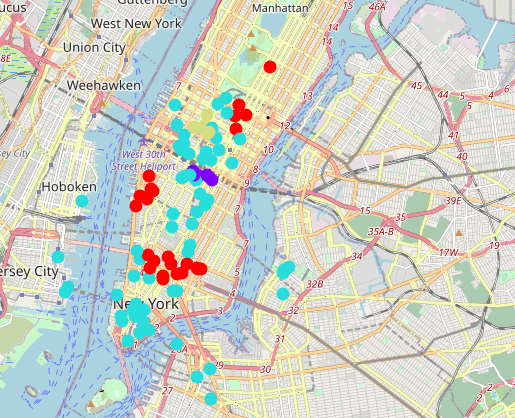

In [53]:
Image(filename='folium_clustering_map.png')

###Examine Clusters

In [54]:
#1
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 0, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Crosby Street Hotel,Boutique,Italian Restaurant,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Sporting Goods Shop,Café,Mediterranean Restaurant,Shoe Store
3,SoHo Grand Hotel,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Women's Store,Bakery,Art Gallery,Coffee Shop,Bar,Boutique
5,"The Standard, High Line",Italian Restaurant,Bakery,Café,Market,Boutique,French Restaurant,Shoe Store,Clothing Store,Seafood Restaurant,Coffee Shop
12,Gansevoort Meatpacking NYC,Bakery,Coffee Shop,Clothing Store,Cosmetics Shop,Boutique,Shoe Store,Roof Deck,Steakhouse,Mediterranean Restaurant,Café
13,Dream Downtown,Bakery,Coffee Shop,Pet Store,Café,Market,Ice Cream Shop,Theater,Bar,Electronics Store,Cocktail Bar
17,citizenM Bowery,Café,Cocktail Bar,Cosmetics Shop,Coffee Shop,Ice Cream Shop,Italian Restaurant,Tea Room,Mediterranean Restaurant,Pizza Place,Bar
24,PUBLIC,Italian Restaurant,Clothing Store,Cosmetics Shop,Cocktail Bar,Coffee Shop,Lounge,Art Gallery,Sushi Restaurant,Garden,Street Art
25,11 Howard,Italian Restaurant,Spa,Clothing Store,Café,Coffee Shop,Bakery,Furniture / Home Store,Bubble Tea Shop,Jewelry Store,Chinese Restaurant
26,The Dominick,Italian Restaurant,French Restaurant,Coffee Shop,American Restaurant,Clothing Store,Office,Boutique,Burger Joint,Gym,Café
28,The Plaza Hotel,Jewelry Store,Italian Restaurant,Boutique,Hotel Bar,Park,Coffee Shop,Women's Store,Salon / Barbershop,Shoe Store,Food Court


In [55]:
#2
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 1, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Ace Hotel New York,Korean Restaurant,Hotel Bar,Dessert Shop,New American Restaurant,Bakery,Gym / Fitness Center,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop
9,Kimpton Hotel Eventi,Korean Restaurant,Coffee Shop,Hotel Bar,Dessert Shop,Karaoke Bar,American Restaurant,Gym / Fitness Center,Salad Place,Cocktail Bar,Pizza Place
50,The Roger New York,Korean Restaurant,Bakery,Café,Gym / Fitness Center,Bar,Juice Bar,Dessert Shop,Pizza Place,Salad Place,Sandwich Place
69,MADE Hotel,Korean Restaurant,Hotel Bar,Italian Restaurant,Café,Coffee Shop,Japanese Restaurant,New American Restaurant,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Lounge
82,Arlo NoMad,Korean Restaurant,Bakery,Gym / Fitness Center,Dessert Shop,Bar,Juice Bar,Japanese Restaurant,Hotel Bar,Fried Chicken Joint,Food Court
86,Mondrian Park Avenue,Korean Restaurant,Indian Restaurant,Gym / Fitness Center,Bakery,American Restaurant,Pizza Place,Café,Bar,Gym,Furniture / Home Store


In [56]:
#3
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 2, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Roxy Hotel,Coffee Shop,Gym / Fitness Center,Spa,French Restaurant,Cocktail Bar,Café,Italian Restaurant,Art Gallery,Bakery,Men's Store
2,Conrad New York Downtown,Park,Coffee Shop,Food Court,Sandwich Place,BBQ Joint,Burger Joint,Gym,Mediterranean Restaurant,Bistro,Mexican Restaurant
4,The Bowery Hotel,Italian Restaurant,Sushi Restaurant,Bar,Mexican Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,Gift Shop,Bookstore,Café
6,Andaz Wall Street - a concept by Hyatt,Boat or Ferry,Coffee Shop,American Restaurant,Pizza Place,Cocktail Bar,Pedestrian Plaza,Falafel Restaurant,Event Space,Bar,Plaza
8,The NoMad Hotel,Hotel Bar,Italian Restaurant,Gym / Fitness Center,Café,Bar,New American Restaurant,Lounge,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop
10,Four Seasons Hotel New York Downtown,Clothing Store,Shopping Mall,Indian Restaurant,Sandwich Place,Women's Store,Park,Hotel Bar,Italian Restaurant,Bookstore,Plaza
11,"The Beekman, A Thompson Hotel",Sandwich Place,Coffee Shop,Pizza Place,Plaza,Italian Restaurant,Deli / Bodega,Park,Clothing Store,Indian Restaurant,Burger Joint
14,Gramercy Park Hotel,American Restaurant,Coffee Shop,Italian Restaurant,Café,New American Restaurant,Thrift / Vintage Store,Restaurant,Bagel Shop,Mexican Restaurant,Health & Beauty Service
15,Hotel 50 Bowery,Chinese Restaurant,Dessert Shop,Bakery,Italian Restaurant,Bubble Tea Shop,Shanghai Restaurant,Dim Sum Restaurant,Grocery Store,Spa,Salon / Barbershop
16,Greenwich Hotel,American Restaurant,Spa,Wine Bar,Café,Italian Restaurant,Steakhouse,Art Gallery,Skate Park,Wine Shop,Park


In [57]:
#4
nearby_venues_merged.loc[nearby_venues_merged['Cluster Labels'] == 3, 
                   nearby_venues_merged.columns[[0] + list(range(4, nearby_venues_merged.shape[1]))]]

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,W New York - Times Square,Theater,Italian Restaurant,Plaza,Coffee Shop,Ice Cream Shop,American Restaurant,Cocktail Bar,Toy / Game Store,Sandwich Place,Clothing Store
20,citizenM Hotel New York Times Square,Theater,Coffee Shop,Italian Restaurant,Sandwich Place,Plaza,Steakhouse,Ramen Restaurant,Sushi Restaurant,American Restaurant,Bar
30,InterContinental New York Times Square,Theater,American Restaurant,Italian Restaurant,Burger Joint,Juice Bar,Japanese Restaurant,Donut Shop,Coffee Shop,Indie Theater,New American Restaurant
47,New York Marriott Marquis,Theater,Italian Restaurant,Plaza,Coffee Shop,Donut Shop,Concert Hall,Bar,Cuban Restaurant,Sushi Restaurant,Toy / Game Store
78,Millennium Broadway Hotel,Theater,Coffee Shop,Plaza,Italian Restaurant,Burger Joint,Bar,Bakery,Cocktail Bar,Clothing Store,Concert Hall
89,Hyatt Centric Times Square New York,Theater,Coffee Shop,Cocktail Bar,Plaza,Italian Restaurant,Bar,Clothing Store,Sushi Restaurant,Toy / Game Store,Sandwich Place


In [58]:
#a function to view the clusters in a different way, grouping and coloring them by each type of cluster
def style_cluster(s):
    
    # set colors used to color rows for each cluster
    colors = ['#39568CFF', '#33638DFF', '#2D708EFF', '#287D8EFF', '#238A8DFF', '#1F968BFF', '#20A387FF', 
              '#29AF7FFF', '#29AF7FFF', '#3CBB75FF', '#55C667FF', '#73D055FF', '#95D840FF', '#B8DE29FF', 
              '#DCE319FF', 'FDE725FF']

    # color row by cluster number
    if s['Cluster Labels'] == 0:
        return ['background-color: {}'.format(colors[0])]*14
    elif s['Cluster Labels'] == 1:
        return ['background-color: {}'.format(colors[3])]*14
    elif s['Cluster Labels'] == 2:
        return ['background-color: {}'.format(colors[5])]*14
    elif s['Cluster Labels'] == 3:
        return ['background-color: {}'.format(colors[7])]*14
    elif s['Cluster Labels'] == 4:
        return ['background-color: {}'.format(colors[9])]*14
    elif s['Cluster Labels'] == 5:
        return ['background-color: {}'.format(colors[11])]*14
    else:
        return ['background-color: {}'.format(colors[13])]*14

# sort and aplly style, by row (axis = 1)
nearby_venues_merged.sort_values('Cluster Labels', ascending=False).style.apply(style_cluster, axis=1)

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,New York Marriott Marquis,40.758725,-73.986243,3,Theater,Italian Restaurant,Plaza,Coffee Shop,Donut Shop,Concert Hall,Bar,Cuban Restaurant,Sushi Restaurant,Toy / Game Store
20,citizenM Hotel New York Times Square,40.761691,-73.984953,3,Theater,Coffee Shop,Italian Restaurant,Sandwich Place,Plaza,Steakhouse,Ramen Restaurant,Sushi Restaurant,American Restaurant,Bar
78,Millennium Broadway Hotel,40.757073,-73.984800,3,Theater,Coffee Shop,Plaza,Italian Restaurant,Burger Joint,Bar,Bakery,Cocktail Bar,Clothing Store,Concert Hall
18,W New York - Times Square,40.759296,-73.985573,3,Theater,Italian Restaurant,Plaza,Coffee Shop,Ice Cream Shop,American Restaurant,Cocktail Bar,Toy / Game Store,Sandwich Place,Clothing Store
30,InterContinental New York Times Square,40.758660,-73.989544,3,Theater,American Restaurant,Italian Restaurant,Burger Joint,Juice Bar,Japanese Restaurant,Donut Shop,Coffee Shop,Indie Theater,New American Restaurant
89,Hyatt Centric Times Square New York,40.757396,-73.984222,3,Theater,Coffee Shop,Cocktail Bar,Plaza,Italian Restaurant,Bar,Clothing Store,Sushi Restaurant,Toy / Game Store,Sandwich Place
62,Freehand New York,40.739740,-73.984622,2,Bar,Thrift / Vintage Store,Coffee Shop,Wine Shop,Bagel Shop,Italian Restaurant,Chinese Restaurant,Café,Indian Restaurant,Gym
71,Wythe Hotel,40.721887,-73.957994,2,Hotel Bar,Bowling Alley,Gym / Fitness Center,Bar,Art Gallery,Roof Deck,Soccer Field,Coffee Shop,Cocktail Bar,New American Restaurant
70,The William Vale Hotel,40.722300,-73.956722,2,Hotel Bar,Bar,Bowling Alley,Gym / Fitness Center,Roof Deck,Cocktail Bar,Art Gallery,Dance Studio,Coffee Shop,Clothing Store
67,New York Marriott Downtown,40.709504,-74.014672,2,Park,Pizza Place,Memorial Site,Jewelry Store,Gourmet Shop,Coffee Shop,Wine Shop,Clothing Store,Playground,Burger Joint


Visualize N Most Common Venues for each Dataset

In [59]:
def cluster_common_venues(data, clusters, n_venues = 5, ax = None, figsize=(20,20)):
    
    # number of clusters
    n_cluster = len(clusters)
    
    # set ax with 2 columns and n_cluster/columns rows for n_cluster even
    # set ax with 1 column and n_clusters rows for n_cluster odd
    if ax is None and (n_cluster%2==0):
        rows = int(n_cluster / 2)
        ax = [rows, 2]
    elif ax is None:
        ax = [n_cluster, 1]
    
    # create axes subplots
    fig, axes = plt.subplots(nrows=ax[0],ncols=ax[1])
    
    ''' 
    When the subplot is made for only 1 line, the returned axes are an object of a single dimension.
    When the subplot has more than 1 line, the returned axes becomes a 2-dimensional object.
    Then, to resolve this conflict, a forced conversion to 2 dimensions is performed for both cases.
    '''
    # set axes as 2d 
    axes = np.atleast_2d(axes)
    
    '''
    When a subplot contains only a single column, its plot indices are exactly the same when
    it only has a single line. ex. for a 1 row x 2 column plot the indices would be: [0, 0], [0.1]
    and for 2 rows and 1 column, the index is the same [0, 0], [0.1].
    Therefore, for this case, it is necessary to invert the values that generate the index list.
    '''
    # for 1 column, invert labels that generate index subplot list
    if ax[1] == 1:
        ax[1] = ax[0]
        ax[0] = 1

    # create list subplot position
    ax_list = []
    for row in range(ax[0]):
        for column in range(ax[1]):
            ax_list.append([row,column])
    
    # subplot n most common venues for each cluster
    for i in range(n_cluster):
        
        # get grouped cluster subset with n most common venues
        group = data.loc[data['Cluster Labels'] == clusters[i]]
        group = group.loc[:, '1st Most Common Venue':'10th Most Common Venue'].stack().value_counts()
        group = round(((group / group.sum()) * 100), 2)
        group_df = pd.DataFrame(group[0:n_venues]).transpose()
        
        # set axes index
        x = ax_list[i][0]
        y = ax_list[i][1]

        # bar plot
        group_df.plot(kind='bar',figsize=figsize, width = 0.8, ax = axes[x,y])
        axes[x,y].set_title("Most Common Venues - Cluster {}".format(clusters[i]), fontsize=16)
        axes[x,y].legend(fontsize=12)
        axes[x,y].set_xticks([])
        axes[x,y].set_xlabel('Cluster {}'.format(clusters[i]), fontsize=16)
        axes[x,y].set_ylabel('Venues %', fontsize=16)
        
    # plot title
    plt.suptitle('{} MOST COMMON VENUES FOR EACH CLUSTER'.format(n_venues), fontsize=20)

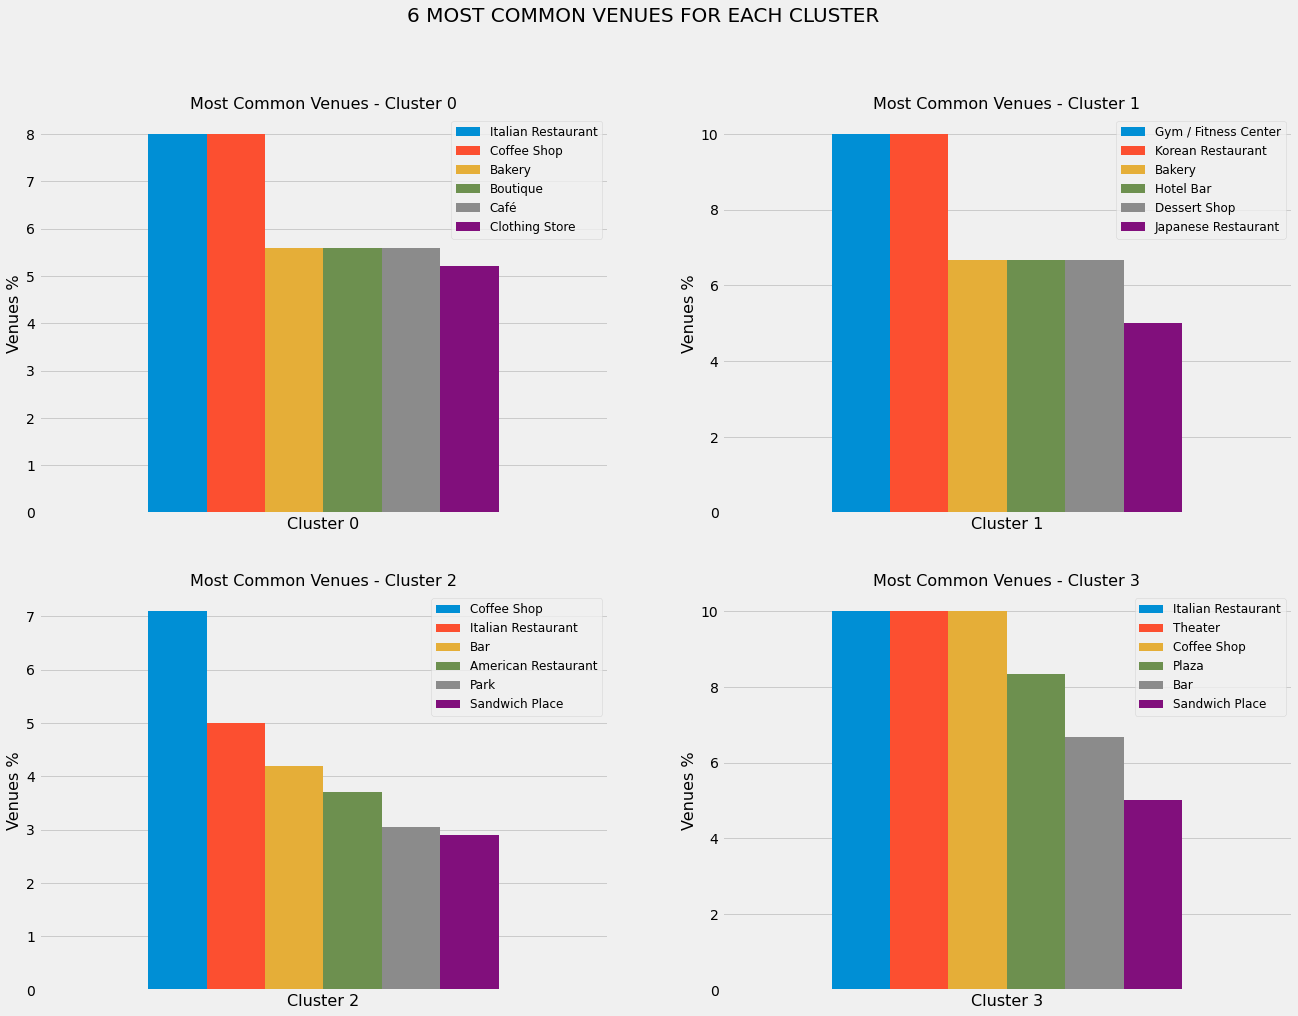

In [60]:
cluster_common_venues(data = nearby_venues_merged, clusters = list(range(4)), figsize=(20,15), n_venues=6)

###Bringing Back the Ratings

In [61]:
hotels_ratings = pd.read_csv('hotels_ratings.csv')
hotels_ratings.head()

,Venue,Venue Id,Ratings
0,The Roxy Hotel,3fd66200f964a520bbe61ee3,8.7
1,Crosby Street Hotel,4ac7e4a7f964a52065ba20e3,9.1
2,Conrad New York Downtown,4f22ca77e4b0ed3396a83a05,8.7
3,SoHo Grand Hotel,3fd66200f964a52053eb1ee3,8.7
4,The Bowery Hotel,4ab04eb9f964a520fe6620e3,9.3


In [62]:
#change the column name
hotels_ratings.rename(columns={'Venue': 'Hotel', 'Venue Id': 'Hotel Id'}, inplace=True)

In [63]:
hotels_ratings.head()

,Hotel,Hotel Id,Ratings
0,The Roxy Hotel,3fd66200f964a520bbe61ee3,8.7
1,Crosby Street Hotel,4ac7e4a7f964a52065ba20e3,9.1
2,Conrad New York Downtown,4f22ca77e4b0ed3396a83a05,8.7
3,SoHo Grand Hotel,3fd66200f964a52053eb1ee3,8.7
4,The Bowery Hotel,4ab04eb9f964a520fe6620e3,9.3


In [64]:
newyork_nearby_venues_merged = pd.read_csv('newyork_nearby_venues_merged.csv')
newyork_nearby_venues_merged.head()

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Roxy Hotel,40.719341,-74.005044,2,Coffee Shop,Gym / Fitness Center,Spa,French Restaurant,Cocktail Bar,Café,Italian Restaurant,Art Gallery,Bakery,Men's Store
1,Crosby Street Hotel,40.723011,-73.997454,0,Boutique,Italian Restaurant,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Sporting Goods Shop,Café,Mediterranean Restaurant,Shoe Store
2,Conrad New York Downtown,40.715035,-74.015840,2,Park,Coffee Shop,Food Court,Sandwich Place,BBQ Joint,Burger Joint,Gym,Mediterranean Restaurant,Bistro,Mexican Restaurant
3,SoHo Grand Hotel,40.721974,-74.004464,0,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Women's Store,Bakery,Art Gallery,Coffee Shop,Bar,Boutique
4,The Bowery Hotel,40.726145,-73.991627,2,Italian Restaurant,Sushi Restaurant,Bar,Mexican Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,Gift Shop,Bookstore,Café


In [65]:
newyork_venues_merged = newyork_nearby_venues_merged.merge(hotels_ratings, on='Hotel')
newyork_venues_merged.head()

,Hotel,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Hotel Id,Ratings
0,The Roxy Hotel,40.719341,-74.005044,2,Coffee Shop,Gym / Fitness Center,Spa,French Restaurant,Cocktail Bar,Café,Italian Restaurant,Art Gallery,Bakery,Men's Store,3fd66200f964a520bbe61ee3,8.7
1,Crosby Street Hotel,40.723011,-73.997454,0,Boutique,Italian Restaurant,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Sporting Goods Shop,Café,Mediterranean Restaurant,Shoe Store,4ac7e4a7f964a52065ba20e3,9.1
2,Conrad New York Downtown,40.715035,-74.015840,2,Park,Coffee Shop,Food Court,Sandwich Place,BBQ Joint,Burger Joint,Gym,Mediterranean Restaurant,Bistro,Mexican Restaurant,4f22ca77e4b0ed3396a83a05,8.7
3,SoHo Grand Hotel,40.721974,-74.004464,0,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Women's Store,Bakery,Art Gallery,Coffee Shop,Bar,Boutique,3fd66200f964a52053eb1ee3,8.7
4,The Bowery Hotel,40.726145,-73.991627,2,Italian Restaurant,Sushi Restaurant,Bar,Mexican Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,Gift Shop,Bookstore,Café,4ab04eb9f964a520fe6620e3,9.3


In [66]:
# get columns name as list
cols = newyork_venues_merged.columns.tolist()

# get Hotel column index and pop (remove) from list
index_hotel = cols.index('Hotel')
cols.pop(index_hotel)

# get Ratings column index and pop (remove) from list
index_ratings = cols.index('Ratings')
cols.pop(index_ratings)

# create list starting with [Hotel, Ratings] + [cols]
cols = ['Hotel', 'Ratings'] + cols

# set new column order
newyork_venues_merged_ratings = newyork_venues_merged[cols]

# heading dataframe
newyork_venues_merged_ratings.head(5)

,Hotel,Ratings,Hotel Latitude,Hotel Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Hotel Id
0,The Roxy Hotel,8.7,40.719341,-74.005044,2,Coffee Shop,Gym / Fitness Center,Spa,French Restaurant,Cocktail Bar,Café,Italian Restaurant,Art Gallery,Bakery,Men's Store,3fd66200f964a520bbe61ee3
1,Crosby Street Hotel,9.1,40.723011,-73.997454,0,Boutique,Italian Restaurant,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Sporting Goods Shop,Café,Mediterranean Restaurant,Shoe Store,4ac7e4a7f964a52065ba20e3
2,Conrad New York Downtown,8.7,40.715035,-74.015840,2,Park,Coffee Shop,Food Court,Sandwich Place,BBQ Joint,Burger Joint,Gym,Mediterranean Restaurant,Bistro,Mexican Restaurant,4f22ca77e4b0ed3396a83a05
3,SoHo Grand Hotel,8.7,40.721974,-74.004464,0,Clothing Store,French Restaurant,Italian Restaurant,Cocktail Bar,Women's Store,Bakery,Art Gallery,Coffee Shop,Bar,Boutique,3fd66200f964a52053eb1ee3
4,The Bowery Hotel,9.3,40.726145,-73.991627,2,Italian Restaurant,Sushi Restaurant,Bar,Mexican Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,Gift Shop,Bookstore,Café,4ab04eb9f964a520fe6620e3


Retrieving information from Rio
First, we need to retrieve the information from my favorite Hotel in Rio.



In [71]:
customer_venue = pd.read_csv('customer_venue.csv')
customer_venue.drop("Unnamed: 0",axis=1, inplace=True)
customer_venue

,City,City Latitude,City Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,"Rio de Janeiro, Brazil",-22.911014,-43.209373,Hilton,591ae35728122f24a87dbcfc,-22.964557,-43.173415,Hotel


In [72]:
customer_venue_grouped = pd.read_csv('customer_venue_grouped.csv')
customer_venue_grouped.drop("Unnamed: 0",axis=1, inplace=True)
customer_venue_grouped

,Hotel,Acai House,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baiano Restaurant,Bakery,Bar,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Café,Candy Store,Central Brazilian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Drugstore,Electronics Store,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Factory,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indie Movie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tapas Restaurant,Tapiocaria,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Restaurant,Tourist Information Center,Toy / Game Store,Track,Tram Station,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Warehouse,Waterfront,Wine Bar,Wings Joint,Women's Store
0,Hilton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.078125,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.109375,0.046875,0.0,0.015625,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.015625,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.015625,0.0,0.015625,0.0,0.0,0.0,0.015625,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.046875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046875,0.0,0.0,0.015625,0.0,0.046875,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.015625,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [73]:
customer_venues_merged = pd.read_csv('customer_venues_merged.csv')
customer_venues_merged

,Hotel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hilton,Brazilian Restaurant,Bar,Restaurant,Beach Bar,Breakfast Spot,Japanese Restaurant,Pharmacy,Pizza Place,Italian Restaurant,Gym / Fitness Center


###Preparing Rio Data
First we need to remove the Hotel column, as it is a feature that is not part of the grouping.

In [74]:
customer_venue_grouped = customer_venue_grouped.drop('Hotel', 1)
customer_venue_grouped

,Acai House,Accessories Store,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baiano Restaurant,Bakery,Bar,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Bus Station,Café,Candy Store,Central Brazilian Restaurant,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cultural Center,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Drugstore,Electronics Store,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Factory,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hostel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indie Movie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Mineiro Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nightclub,Noodle House,Northeastern Brazilian Restaurant,Northern Brazilian Restaurant,Office,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastelaria,Pastry Shop,Pedestrian Plaza,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Portuguese Restaurant,Pub,Public Art,Racecourse,Racetrack,Record Shop,Recreation Center,Rental Car Location,Resort,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southeastern Brazilian Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Fair,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tapas Restaurant,Tapiocaria,Tattoo Parlor,Tea Room,Theater,Theme Park,Theme Restaurant,Tourist Information Center,Toy / Game Store,Track,Tram Station,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Volleyball Court,Warehouse,Waterfront,Wine Bar,Wings Joint,Women's Store
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.078125,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.109375,0.046875,0.0,0.015625,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.015625,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.015625,0.0,0.015625,0.0,0.0,0.0,0.015625,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.046875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046875,0.0,0.0,0.015625,0.0,0.046875,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0.015625,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015625,0

Although I look for similarity between the place of accommodation in Rio and the clusters of New York, they have differences - one of them is that in the Rio hotel dataset there is not the same variety of places observed in NY. So, it is necessary to transform the Rio dataset so that it has the same columns as expected in the NY dataset, so that the classification of Rio to a NY cluster can be performed.

Such a transformation is done by removing the columns from Rio that are not present in NY, and adding with 0 values the columns that are present in NY, but are not part of Rio.

In [75]:
merge_df_cols = customer_venue_grouped.columns.tolist()
df_cols = get_venues_grouped_clustering.columns.tolist()

# get columns name diffence between dataframes
difference = set(df_cols) - set(merge_df_cols)

# remove the different columns between two lists
for venue in difference:
    try:
        merge_df_cols.remove(venue)
    except:
        pass

# get the new differences
difference = set(df_cols) - set(merge_df_cols)

# completing different columns with np_zero values
for column in difference:
    customer_venue_grouped[column] = np.float64(0)
    
# set new column order
merge_df = customer_venue_grouped[df_cols]
merge_df

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restauran

With the classification carried out, we can suggest the top 5 Hotels by rating for the cluster found

In [82]:
suggestion = newyork_venues_merged_ratings.loc[newyork_venues_merged_ratings['Cluster Labels'] == cluster, 
                         newyork_venues_merged_ratings.columns[[0,1] + list(range(4, newyork_venues_merged_ratings.shape[1]))]].sort_values('Ratings', ascending=False).head(5)
suggestion

,Hotel,Ratings,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Hotel Id
4,The Bowery Hotel,9.3,2,Italian Restaurant,Sushi Restaurant,Bar,Mexican Restaurant,Clothing Store,Japanese Restaurant,Coffee Shop,Gift Shop,Bookstore,Café,4ab04eb9f964a520fe6620e3
9,Four Seasons Hotel New York Downtown,9.3,2,Clothing Store,Shopping Mall,Indian Restaurant,Sandwich Place,Women's Store,Park,Hotel Bar,Italian Restaurant,Bookstore,Plaza,57c640ad498e74977f98372f
70,The William Vale Hotel,9.2,2,Hotel Bar,Bar,Bowling Alley,Gym / Fitness Center,Roof Deck,Cocktail Bar,Art Gallery,Dance Studio,Coffee Shop,Clothing Store,56f32b83cd1058e40988b7e4
20,1 Hotel Brooklyn Bridge,9.1,2,Park,Ice Cream Shop,Boat or Ferry,Scenic Lookout,Juice Bar,Pizza Place,Pier,Café,Playground,American Restaurant,57ed4330498e34539123c310
10,"The Beekman, A Thompson Hotel",9.1,2,Sandwich Place,Coffee Shop,Pizza Place,Plaza,Italian Restaurant,Deli / Bodega,Park,Clothing Store,Indian Restaurant,Burger Joint,56d8c0f8498edb854f926e6a


Most Common Venues for Suggested Cluster

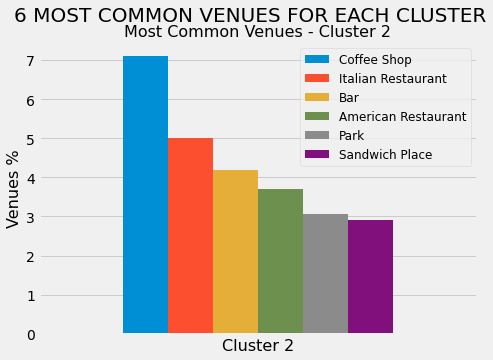

In [79]:
cluster_common_venues(data = nearby_venues_merged, clusters = [cluster], figsize=(7,5), n_venues=6)

Getting DataFrame with lat-long coordinates to the recommended hotels

In [83]:
suggestion_map = hotel_venues.loc[hotel_venues['Hotel'].isin(suggestion['Hotel'].to_list())]
suggestion_map

,Hotel,Hotel Latitude,Hotel Longitude
4,The Bowery Hotel,40.726145,-73.991627
10,Four Seasons Hotel New York Downtown,40.712612,-74.009380
11,"The Beekman, A Thompson Hotel",40.711173,-74.006702
22,1 Hotel Brooklyn Bridge,40.702228,-73.995380
70,The William Vale Hotel,40.722300,-73.956722


Making a map with recommended hotels

In [84]:
# create map of hotels using latitude and longitude values
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=12.5)

code_color = '#2776DB'
# add markers to map
for lat, lng, venue in zip(suggestion_map['Hotel Latitude'], suggestion_map['Hotel Longitude'], 
                                           suggestion_map['Hotel']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=code_color,
        fill=True,
        fill_color=code_color,
        fill_opacity=1,
        parse_html=False).add_to(map_hotels)  
    
map_hotels

As the map created above is interactive, it  not be visible on github

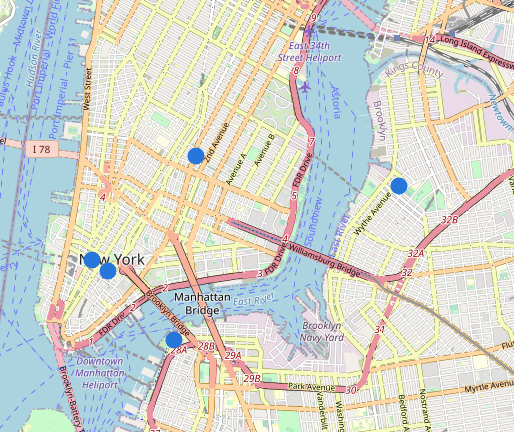

In [85]:
Image(filename='folium_suggested_hotels_map.png')

###Conclusion

With the data obtained via requests to the Foursquare API we were able to collect and group several hotels in the city of New York, and able to find the best hotels for accommodation based on such data.

Despite the satisfactory result for a first version of this project, there are a lot of things that can be improved in future works, such as using more than one data source, gaining access to a higher number of requests to the Foursquare API, use other metrics to evaluate our model and choose the best number of clusters, perform the segmentation for a set that contains more than one city, in short, there are many possibilities, so now it remains to continue the studies and to improve the projects developed with the knowledge acquired over time.